In [1]:
from turtle import color
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
from seq import seqDataLoader
from voc import Vocab,read_dataset,tokenize
from model import RnnModelScratch
from tqdm import tqdm


In [2]:
def create_vocabulary(file):
    # 加载数据集 和 词表
    lines = read_dataset(file)
    tokens = tokenize(lines)
    corpus = [tk for token in tokens for tk in token]
    voc = Vocab(corpus)
    return voc,corpus

def train(net,corpus,epoches,device='cpu',lr=1):

  dataLoader = seqDataLoader(corpus,batch_size=16,num_steps=5,is_random=True)

  loss = nn.CrossEntropyLoss()
  if isinstance(net,nn.Module):
    opt = torch.optim.SGD(net.parameters(),lr=lr)
  else:
    opt = torch.optim.SGD(net.params,lr=lr)
  state = None

  total_losses = []
  with tqdm(total = epoches,desc='模型训练中') as pbar:
    for epoch in range(epoches):
      losses = train_epoch(net,state,dataLoader,loss,opt,is_random=True,device=device)
      total_losses.append(losses)
      if (epoch+1) % 1 == 0:
        pbar.update(1)
        
  return total_losses



def train_epoch(model,state,train_iter,loss,opt,is_random=False,device='cpu'):
  losses = 0
  total = 0
  for X,Y in train_iter:   # 有个 batches 数量的 序列，并且序列式拥有顺序的
    if state is None or is_random:
      state = model.begin_state(X.shape[0],device)
    else:
      for s in state:   
        s.detach_()     # 对每个batch执行时间步截断
  
    X = X.to(device)
    y_pre,state = model(X,state)
    y = F.one_hot(Y.T.reshape(-1),num_classes=y_pre.shape[-1]).float().to(device)
    l = loss(y_pre,y).mean()
    opt.zero_grad()
    l.backward()
    clip_grad(model,1)
    opt.step()
    losses += l.item() * X.size(0)
    total += X.size(0)
  return losses/total


def clip_grad(model,theta):
  if isinstance(model,nn.Module):
    params = [p for p in model.parameters() if p.requires_grad]   # model.parameters()  返回的是参数迭代对象，每个迭代对象是各层网络的参数矩阵
  else:
    params: list = model.params

  tmp = sum(torch.sum(p ** 2) for p in params)
  norm = torch.sqrt(tmp)

  if norm > theta:
    for p in params:
      p.grad = p.grad * theta / norm


In [3]:
device = 'cuda:0'
voc,corpus = create_vocabulary('../dataset/time_machine.txt')
corpus = voc[corpus]
# 加载模型
net = RnnModelScratch(voc_size=len(voc),num_hiddens=256,device=device)
total_losses = train(net,corpus,100,device,lr=1)

模型训练中: 100%|██████████████████████████████████████████████████████████| 100/100 [03:13<00:00,  1.93s/it]


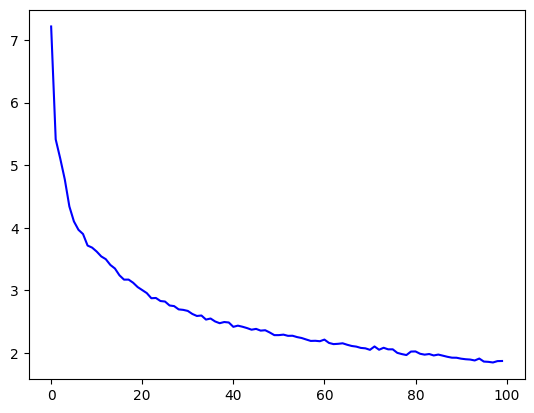

In [4]:
plt.plot(range(len(total_losses)),total_losses,color='blue')
plt.show()

In [5]:
def predict(corpus,prex_nums,model,device):
    outputs = [ corpus[0] ]
    def get_data():
        return torch.tensor(outputs[-1]).reshape(1,1).to(device)
    H = model.begin_state(1,device)
    for i in corpus[1:]:
        _,H = model(get_data(),H)
        outputs.append(i)
    for i in range(prex_nums):
        y,H = model(get_data(),H)
        y = torch.argmax(y,dim=-1).item()
        outputs.append(y)
    return outputs
    

In [7]:
with torch.no_grad():
    str = 'time traveller '
    str = str.split()
    corpus = voc[str]
    print(corpus)
    predict_str = predict(corpus,10,net,device)
    print(predict_str)
    predict_str = ' '.join(voc(predict_str))
    print(predict_str)

[19, 75]
[19, 75, 56, 441, 1599, 120, 1, 46, 1584, 1, 19, 75]
time traveller s return xvi after the machine iii the time traveller
